In [2]:
#Transfer Learning tutorial

# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy

plt.ion()  #interactive mode

In [22]:
#Load Data


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms= {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir= 'C:\\Users\\soumyama\\Documents\\Python Scripts\\PyTorch_Tutorial\\data\\hymenoptera_data'

image_datasets= {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
data_loaders= {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) 
               for x in ['train', 'val']}
dataset_sizes= {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names= image_datasets['train'].classes

device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

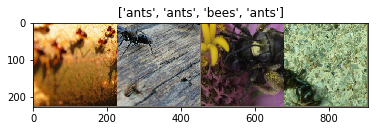

In [23]:
#Visualize a few images

def imshow(inp, title=None):
    inp= inp.numpy().transpose((1,2,0))
    mean= np.array([0.485, 0.456, 0.406])
    std= np.array([0.229, 0.224, 0.225])
    inp= std*inp + mean
    inp= np.clip(inp, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    

#Get a batch of training data
inputs, classes= next(iter(data_loaders['train']))

#Make grid from batch
out= torchvision.utils.make_grid(inputs)

imshow(out, title= [class_names[x] for x in classes])

In [61]:
#Training the model
# -->Scheduling the learning rate
# -->Saving the best model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since =time.time()
    
    best_model_wts= copy.deepcopy(model.state_dict())
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        #Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() #Set model to training mode
                
            else:
                model.eval() #Set model to evaluate model
                
            running_loss= 0.0
            running_corrects=0
            
            #Iterate over data
            for inputs, labels in data_loaders[phase]:
                inputs= inputs.to(device)
                labels= labels.to(device)
                
                #zero the parameter gradients
                
                optimizer.zero_grad()
                
                #forward
                #track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs= model(inputs)
                    _, preds= torch.max(outputs, 1)
                    loss= criterion(outputs, labels)
                    
                    #backward + optimize only if in training phase
                    if phase== 'train':
                        loss.backward()
                        optimizer.step()
                        
                #statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
            
            epoch_loss= running_loss/dataset_sizes[phase]
            epoch_acc= running_corrects.double()/ dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #Deep copy the model
            if phase == 'val' and epoch_acc> best_acc:
                best_acc=epoch_acc
                best_model_wts= copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed= time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    
    print('Best val Acc: {:4f}'.format(best_acc))
    
    #Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [78]:
#Visualizing the model prediction

def visualize_model(model, num_images=6):
    was_training= model.training
    model.eval()
    images_so_far= 0
    fig=plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs= inputs.to(device)
            labels= labels.to(device)
            
            outputs= model(inputs)
            _, preds= torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax= plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far== num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
    

In [74]:
#Finetuning the Convnet

model_ft= models.resnet18(pretrained=True)
num_ftrs=model_ft.fc.in_features
model_ft.fc= nn.Linear(num_ftrs, 2)

model_ft= model_ft.to(device)

criterion=nn.CrossEntropyLoss()

#Observe that all parameters are being optimised
optimizer_ft= optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler= lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [75]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=24)

Epoch 0/23
----------
train Loss: 0.6527 Acc: 0.6557
val Loss: 0.2615 Acc: 0.9085

Epoch 1/23
----------
train Loss: 0.5189 Acc: 0.7828
val Loss: 0.2386 Acc: 0.8954

Epoch 2/23
----------
train Loss: 0.4319 Acc: 0.8361
val Loss: 0.2248 Acc: 0.9085

Epoch 3/23
----------
train Loss: 0.5205 Acc: 0.7910
val Loss: 0.5584 Acc: 0.8039

Epoch 4/23
----------
train Loss: 0.4257 Acc: 0.8484
val Loss: 0.2259 Acc: 0.9281

Epoch 5/23
----------
train Loss: 0.5498 Acc: 0.8156
val Loss: 0.3339 Acc: 0.8889

Epoch 6/23
----------
train Loss: 0.5187 Acc: 0.7869
val Loss: 1.0523 Acc: 0.7582

Epoch 7/23
----------
train Loss: 0.5204 Acc: 0.8115
val Loss: 0.2094 Acc: 0.9281

Epoch 8/23
----------
train Loss: 0.4025 Acc: 0.8443
val Loss: 0.2333 Acc: 0.9085

Epoch 9/23
----------
train Loss: 0.2798 Acc: 0.8607
val Loss: 0.2032 Acc: 0.9281

Epoch 10/23
----------
train Loss: 0.3241 Acc: 0.8975
val Loss: 0.1659 Acc: 0.9346

Epoch 11/23
----------
train Loss: 0.3332 Acc: 0.8811
val Loss: 0.1724 Acc: 0.9412

Ep

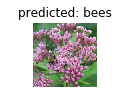

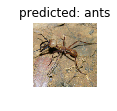

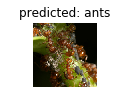

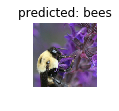

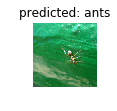

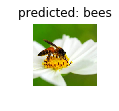

In [79]:
#Visualize model

visualize_model(model_ft)

In [83]:
#ConvNet as fixed feature extractor

model_conv= torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad=False
    
#Parameters of newly constructed modules have requires_grad=True by default
num_ftrs= model_conv.fc.in_features
model_conv.fc= nn.Linear(num_ftrs, 2)

model_conv= model_conv.to(device)

criterion= nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before
optimizer_conv= optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler= lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [85]:
#Train and Evaluate

model_conv= train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6453 Acc: 0.6598
val Loss: 0.5608 Acc: 0.7190

Epoch 1/24
----------
train Loss: 0.5392 Acc: 0.7377
val Loss: 0.1959 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.4254 Acc: 0.8074
val Loss: 0.2143 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3430 Acc: 0.8402
val Loss: 0.2719 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4358 Acc: 0.8033
val Loss: 0.2477 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3841 Acc: 0.8279
val Loss: 0.4487 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.5189 Acc: 0.7582
val Loss: 0.2148 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3699 Acc: 0.8361
val Loss: 0.1928 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3500 Acc: 0.8402
val Loss: 0.1919 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3675 Acc: 0.8320
val Loss: 0.1993 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4208 Acc: 0.8156
val Loss: 0.1919 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3870 Acc: 0.8156
val Loss: 0.1958 Acc: 0.9346

Ep

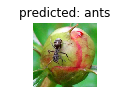

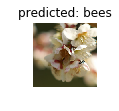

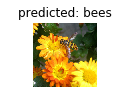

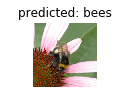

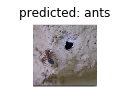

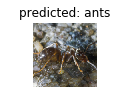

In [86]:
visualize_model(model_conv)

plt.ioff()
plt.show()